ML model for Formula One.

In [1]:
"""
%pip install -U tensorflow
%pip install -U keras
%pip install -U pymongo
%pip install -U colorama
"""

'\n%pip install -U tensorflow\n%pip install -U keras\n%pip install -U pymongo\n%pip install -U colorama\n'

In [2]:
# 
# Import required libraries
#
import sys
import os
import datetime 
import tensorflow                                      as tf
import shutil                                          as shu
import warnings                                        as warn
import pandas                                          as pd
import matplotlib.pyplot                               as plt
import numpy
from   pymongo                 import MongoClient
from   pprint                  import pprint
from   colorama                import Style            as st
from   colorama                import Fore             
from   colorama                import Back             as bk
from   sklearn.model_selection import train_test_split as tts
from   sklearn.preprocessing   import StandardScaler   as sts
from   sklearn.linear_model    import LinearRegression
from   tensorflow              import keras            as ker
from   keras.models            import Sequential       as seq
from   keras.layers            import Dense            as den
from   sklearn.metrics         import classification_report
warn.filterwarnings("ignore", category=DeprecationWarning)
warn.filterwarnings("ignore", category=FutureWarning)
warn.filterwarnings("ignore", category=UserWarning)

In [3]:
#
# Environment Setup
#
start_time = datetime.datetime.now()
w, h       = shu.get_terminal_size()
def printSeparator():
    print(Fore.GREEN + '-' * w + Fore.WHITE)
def logStep(msg):
    l1 = len(msg)
    l2 = w - l1
    print(Fore.WHITE  + str(datetime.datetime.now()) +  " " + 
          Fore.YELLOW + msg + Fore.WHITE + "-" * l2  )
    sys.stdout.flush()
logStep("ENVIRONMENT PREPARATION")
def printDFinfo(name,dfName):
    printSeparator()
    print('Name: ',name)
    printSeparator()
    print(dfName.info())
    printSeparator()
    print(f'Row Count :{Fore.RED}')
    print(dfName.count(),Fore.WHITE)
    printSeparator()
    print(dfName.head())
    printSeparator()
def runtime_Diff(step_Number, step_Message1,base_SQL, cached_SQL):
  start_time          = datetime.datetime.now()
  logStep(step_Number + " - RUNTIME DIFFERENCE")
  time_difference     = base_SQL - cached_SQL
  logStep(F"{step_Number} - Time required for a non-cached Query : {base_SQL}")
  logStep(F"{step_Number} - Time required for a cached/part Query: {cached_SQL}")
  logStep(F"{step_Number} - Time difference                      : {time_difference}")
  logStep(step_Number + " - DONE")
  end_time            = datetime.datetime.now()
  step_elapsed_time   = end_time - start_time
  logStep(F"{step_Number} - ELAPSED TIME: {step_elapsed_time} seconds")
  return step_elapsed_time
print(F"Copyright                              : {sys.copyright}")
print(F"OS Platform                            : {sys.platform}")
print(F"OS Name                                : {os.name}")
print(F"OS HOME                                : {os.environ.get('HOME')}")
print(F"OS uName                               : {os.uname().sysname}")
print(F"OS NodeName                            : {os.uname().nodename}")
print(F"OS Release                             : {os.uname().release}")
print(F"OS Release Ver                         : {os.uname().version}")
print(F"OS Machine                             : {os.uname().machine}")
print(F"Process ID                             : {os.getpid()}")
print(F"Parent Process                         : {os.getppid()}")
print(F"OS User                                : {os.getlogin()}")
print(F"OS User ID                             : {os.getuid()}")
print(F"OS Group ID                            : {os.getgid()}")
print(F"OS Effective ID                        : {os.geteuid()}")
print(F"OS Effective GID                       : {os.getegid()}")
print(F"Current dir                            : {os.getcwd()}")
print(F"Python version                         : {sys.version}")
print(F"Version info                           : {sys.version_info}")
print(F"Python API Ver                         : {sys.api_version}")
print(F"Executable                             : {sys.executable}")
print(F"Spark UI                               : http://localhost:4040")
print(F"Spark submit                           : {sys.argv[0]}")
print(F"Hadoop Home                            : {os.environ.get('HADOOP_HOME')}")
print(F"Java Home                              : {os.environ.get('JAVA_HOME')}")
print(F"Current Working Directory              : {os.getcwd()}")
logStep("DONE");
end_time            = datetime.datetime.now()
step00_elapsed_time = end_time - start_time
logStep(F"ELAPSED TIME: {step00_elapsed_time} seconds")

2023-10-06 15:19:05.987009 ENVIRONMENT PREPARATION---------------------------------------------------------
Copyright                              : Copyright (c) 2001-2023 Python Software Foundation.
All Rights Reserved.

Copyright (c) 2000 BeOpen.com.
All Rights Reserved.

Copyright (c) 1995-2001 Corporation for National Research Initiatives.
All Rights Reserved.

Copyright (c) 1991-1995 Stichting Mathematisch Centrum, Amsterdam.
All Rights Reserved.
OS Platform                            : darwin
OS Name                                : posix
OS HOME                                : /Users/eneas
OS uName                               : Darwin
OS NodeName                            : MBPJES14M2.local
OS Release                             : 23.1.0
OS Release Ver                         : Darwin Kernel Version 23.1.0: Tue Sep 26 22:11:58 PDT 2023; root:xnu-10002.40.89.501.1~3/RELEASE_ARM64_T6020
OS Machine                             : arm64
Process ID                             : 67

In [4]:
logStep('Environment Preparation')
mongo = MongoClient(port=27017)
print(mongo.list_database_names())
db    = mongo['F1']
print(db.list_collection_names())
Results = db['Results']
logStep('Environment Preparation Completed')

2023-10-06 15:19:05.992009 Environment Preparation---------------------------------------------------------
['F1', 'admin', 'config', 'local', 'met', 'uk_food']
['Drivers', 'Teams', 'Results']
2023-10-06 15:19:06.000413 Environment Preparation Completed-----------------------------------------------


In [5]:
logStep('Model Preparation')
query  = ({"$and":[{"Position" : {"$gt": 0}},
                   {"Year"     : 2022}]})
fields = {'Position'  : 1,
          'Driver': 1,
          'Starting Grid': 1,
          'Laps': 1,
          'Points': 1}
results    = Results.find(query,fields)
results_df = pd.DataFrame(list(results))
results_df = results_df.drop(columns=['_id'])
print(results_df.head())
logStep('Model Preparation Completed')

2023-10-06 15:19:06.003424 Model Preparation---------------------------------------------------------------
   Position           Driver  Starting Grid  Laps  Points
0         1  Charles Leclerc            1.0    57    26.0
1         2     Carlos Sainz            3.0    57    18.0
2         3   Lewis Hamilton            5.0    57    15.0
3         4   George Russell            9.0    57    12.0
4         5  Kevin Magnussen            7.0    57    10.0
2023-10-06 15:19:06.008492 Model Preparation Completed-----------------------------------------------------


In [6]:
printDFinfo('results_df',results_df)

--------------------------------------------------------------------------------
Name:  results_df
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Position       220 non-null    int64  
 1   Driver         220 non-null    object 
 2   Starting Grid  220 non-null    float64
 3   Laps           220 non-null    int64  
 4   Points         220 non-null    float64
dtypes: float64(2), int64(2), object(1)
memory usage: 8.7+ KB
None
--------------------------------------------------------------------------------
Row Count :
Position         220
Driver           220
Starting Grid    220
Laps             220
Points           220
dtype: int64 
--------------------------------------------------------------------------------
   Position           Driver  Starting Grid  Lap

In [7]:
#
# Log the processing progress
#
logStep('Model Preparation')
# 
# Determine the number of unique values in each column.
#
printSeparator()
print('results_df.nunique()')
printSeparator()
print(results_df.nunique())
printSeparator()
logStep('Model Preparation')
# 

2023-10-06 15:19:06.017794 Model Preparation---------------------------------------------------------------
--------------------------------------------------------------------------------
results_df.nunique()
--------------------------------------------------------------------------------
Position         10
Driver           21
Starting Grid    20
Laps             19
Points           16
dtype: int64
--------------------------------------------------------------------------------
2023-10-06 15:19:06.019124 Model Preparation---------------------------------------------------------------


In [8]:
#
# Log the processing progress
#
logStep('For columns that have more than 10 unique values, determine the number of data points for each unique value.')

for column_Name in results_df.columns:
    if results_df[column_Name].nunique() > 10:
        print('Column Name', column_Name)
        printSeparator()
        print(results_df[column_Name].value_counts())
        printSeparator()
logStep('determined the number of data points for each unique value.')

2023-10-06 15:19:06.023982 For columns that have more than 10 unique values, determine the number of data points for each unique value.
Column Name Driver
--------------------------------------------------------------------------------
Driver
Max Verstappen      20
George Russell      20
Sergio Perez        19
Charles Leclerc     19
Lewis Hamilton      19
Lando Norris        17
Esteban Ocon        16
Carlos Sainz        16
Fernando Alonso     14
Sebastian Vettel    10
Valtteri Bottas      9
Lance Stroll         8
Daniel Ricciardo     7
Kevin Magnussen      6
Pierre Gasly         6
Yuki Tsunoda         4
Alexander Albon      3
Guanyu Zhou          3
Mick Schumacher      2
Nyck De Vries        1
Nicholas Latifi      1
Name: count, dtype: int64
--------------------------------------------------------------------------------
Column Name Starting Grid
--------------------------------------------------------------------------------
Starting Grid
2.0     20
3.0     20
1.0     18
6.0     18
7.

In [9]:
results_df.insert(0,'Champion',0)
print(results_df)

     Champion  Position            Driver  Starting Grid  Laps  Points
0           0         1   Charles Leclerc            1.0    57    26.0
1           0         2      Carlos Sainz            3.0    57    18.0
2           0         3    Lewis Hamilton            5.0    57    15.0
3           0         4    George Russell            9.0    57    12.0
4           0         5   Kevin Magnussen            7.0    57    10.0
..        ...       ...               ...            ...   ...     ...
215         0         6      Lando Norris            7.0    58     9.0
216         0         7      Esteban Ocon            8.0    58     6.0
217         0         8      Lance Stroll           14.0    58     4.0
218         0         9  Daniel Ricciardo           13.0    58     2.0
219         0        10  Sebastian Vettel            9.0    58     1.0

[220 rows x 6 columns]


In [10]:
#
# Log the processing progress
#
logStep('Use  pd.get_dummies()  to encode categorical variables.')
#
# Convert categorical data to numeric with `pd.get_dummies`
#
results_df_numeric = pd.get_dummies(results_df)
printDFinfo('results_df_numeric',results_df_numeric)

2023-10-06 15:19:06.041037 Use  pd.get_dummies()  to encode categorical variables.-------------------------
--------------------------------------------------------------------------------
Name:  results_df_numeric
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Champion                 220 non-null    int64  
 1   Position                 220 non-null    int64  
 2   Starting Grid            220 non-null    float64
 3   Laps                     220 non-null    int64  
 4   Points                   220 non-null    float64
 5   Driver_Alexander Albon   220 non-null    bool   
 6   Driver_Carlos Sainz      220 non-null    bool   
 7   Driver_Charles Leclerc   220 non-null    bool   
 8   Driver_Daniel Ricciardo  220 non-null    bool   
 9   

In [11]:
#
# Log the processing progress
#
logStep('Preprocess the Data')
# 
# Split our preprocessed data into our features and target arrays
#
results_df_numeric.dropna()
X = results_df_numeric.drop(['Champion'], axis=1)
y = results_df_numeric['Champion']
#
# Split the preprocessed data into a training and testing dataset
#
X_train, X_test, y_train, y_test = tts(X, y, random_state=58)
print('X_train.shape')
print(X_train.shape)
printSeparator()
print('X_test.shape')
print(X_test.shape)
printSeparator()
print('y_train.shape')
print(y_train.shape)
printSeparator()
print('y_test.shape')
print(y_test.shape)
printSeparator()

2023-10-06 15:19:06.050268 Preprocess the Data-------------------------------------------------------------
X_train.shape
(165, 25)
--------------------------------------------------------------------------------
X_test.shape
(55, 25)
--------------------------------------------------------------------------------
y_train.shape
(165,)
--------------------------------------------------------------------------------
y_test.shape
(55,)
--------------------------------------------------------------------------------


In [12]:
#
# Log the processing progress
#
logStep('Scale the training and testing features datasets')
#
# Create a Standard Scaler instance
# Fit the Standard Scaler
# Scale the data
#
scaler         = sts()
X_scaler       = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)
#
# Log the processing progress
#
print('X_train_scaled.shape')
print(X_train_scaled.shape)
printSeparator()
print('X_test_scaled.shape')
print(X_test_scaled.shape)
printSeparator()

2023-10-06 15:19:06.055413 Scale the training and testing features datasets--------------------------------
X_train_scaled.shape
(165, 25)
--------------------------------------------------------------------------------
X_test_scaled.shape
(55, 25)
--------------------------------------------------------------------------------


In [13]:
#
# Log the processing progress
#
logStep('Define the model parameters')
# 
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#
number_input_features = len(X_train_scaled[0]) # type: ignore
hidden_nodes_layer1   = 12
hidden_nodes_layer2   = 12
nn_model              = seq()
#
# First hidden layer
#
nn_model.add(den(units=hidden_nodes_layer1,input_dim=number_input_features, activation="tanh"))
#
# Second hidden layer
#
nn_model.add(den(units=hidden_nodes_layer2, activation="tanh"))
#
# Output layer
#
nn_model.add(den(units=1, activation="tanh"))
#
# Check the structure of the model
#
nn_model.summary()
printSeparator()
#
# Log the processing progress
#
logStep('10 - Compile the model')
# 
# Compile the model
#
nn_model.compile(loss      = 'binary_crossentropy', 
                 optimizer = 'adam', 
                 metrics   = ['accuracy'])
print('Model compiled')
printSeparator()
#
# Log the processing progress
#
logStep('Train the model parameters')
# 
# Train the model
#
print('Model Training')
printSeparator()
fit_model = nn_model.fit(X_train_scaled,y_train,epochs=50)
printSeparator()
print('Model Training Complete')
printSeparator()

2023-10-06 15:19:06.062438 Define the model parameters-----------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                312       
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
--------------------------------------------------------------------------------
2023-10-06 15:19:06.094465 10 - Compile the model----------------------------------------------------------
Model compiled
----------

2023-10-06 15:19:06.119145: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6/6 [==============================] - 0s 588us/step - loss: 0.0494 - accuracy: 0.9879
Epoch 9/50
6/6 [==============================] - 0s 593us/step - loss: 0.0314 - accuracy: 1.0000
Epoch 10/50
6/6 [==============================] - 0s 524us/step - loss: 0.0215 - accuracy: 1.0000
Epoch 11/50
6/6 [==============================] - 0s 561us/step - loss: 0.0153 - accuracy: 1.0000
Epoch 12/50
6/6 [==============================] - 0s 585us/step - loss: 0.0101 - accuracy: 1.0000
Epoch 13/50
6/6 [==============================] - 0s 560us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 14/50
6/6 [==============================] - 0s 546us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 15/50
6/6 [==============================] - 0s 519us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 16/50
6/6 [==============================] - 0s 543us/step - loss: 0.0029 - accuracy: 1.0000
Epoch 17/50
6/6 [==============================] - 0s 534us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 18/50
6/6 [======

2023-10-06 15:19:06.492449 Evaluate the model parameters---------------------------------------------------
2/2 [==============================] - 0s 1ms/step - loss: 0.0054 - accuracy: 1.0000
Loss: 0.01, Accuracy: 1.00
Accuracy is 100.00%, greater than or equal to 75%
Model is optimized


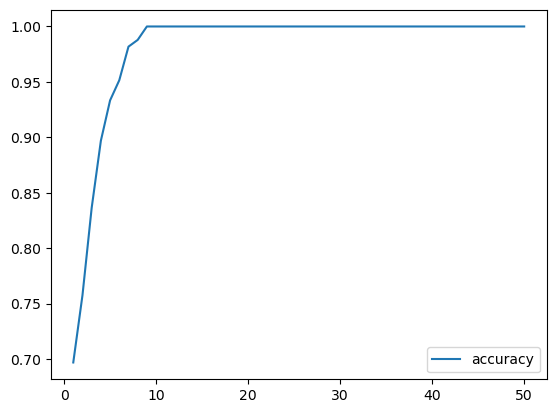

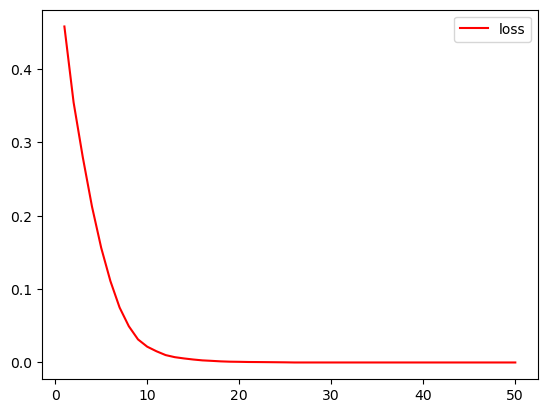

2023-10-06 15:19:06.750512 13 - Export the model to a HDF5 file--------------------------------------------
--------------------------------------------------------------------------------
Model saved to file :  Output/F1_model.h5
--------------------------------------------------------------------------------
End of processing


In [14]:
#
# Log the processing progress
#
logStep('Evaluate the model parameters')
# 
# Evaluate the model using the test data
#
skip_optimization = False
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test)
print(f"Loss: {model_loss:2.2f}, Accuracy: {model_accuracy:2.2f}")
accuracy = model_accuracy * 100
if (accuracy < 75):   
    print(F'Accuracy is {accuracy:2.2f}%, less than 75%')
    print("More optimization is required")
else:
    print(F'Accuracy is {accuracy:2.2f}%, greater than or equal to 75%')
    print("Model is optimized")
    history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))
    history_df.plot(y="accuracy")
    plt.show()
    history_df.plot(y="loss",color='red')
    plt.show()
    #
    # Log the processing progress
    #
    logStep('13 - Export the model to a HDF5 file')
    # 
    # Export our model to HDF5 file
    #
    filename = 'Output/F1_model.h5'
    #
    # Save the model to a HDF5 file
    #
    nn_model.save(filename)
    printSeparator()
    print('Model saved to file : ',filename)
    printSeparator()
    print('End of processing')
    skip_optimization = True

In [15]:
#
# Log the processing progress
#
if skip_optimization == False:
  logStep('Attempt 2 - Add more neurons to a hidden layer')
  number_input_features = len(X_train_scaled[0]) # type: ignore
  print('Number of input features : ',number_input_features)
  for nodes in range(14, 140, 2):
    printSeparator()
    print('Number of hidden nodes   : ',nodes)
    hidden_nodes_layer1   = nodes
    hidden_nodes_layer2   = nodes
    hidden_nodes_layer3   = nodes
    hidden_nodes_layer4   = nodes
    hidden_nodes_layer5   = nodes
    nn_model2             = seq(name=f"Optimized_Model_{nodes}")
    nn_model2.add(den(units=hidden_nodes_layer1,input_dim=number_input_features, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer2, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer3, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer4, activation="tanh"))
    nn_model2.add(den(units=hidden_nodes_layer5, activation="tanh"))
    nn_model2.add(den(units=1,activation="tanh"))
    nn_model2.summary()
    printSeparator()
    print('Compile the model')
    nn_model2.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics   = ['accuracy'])
    print('Model compiled')
    printSeparator()
    print('Fit the model')
    fit_model2 = nn_model2.fit(X_train_scaled,y_train,epochs=50)
    print('Model fit')
    printSeparator()
    print('Evaluate the model')
    model_loss2, model_accuracy2 = nn_model2.evaluate(X_test_scaled,y_test)
    print(f"Loss: {model_loss2:2.2f}, Accuracy: {model_accuracy2:2.2f}")
    accuracy2 = model_accuracy2 * 100
    if (accuracy2 < 75):   
      print(F'Accuracy is {accuracy2:2.2f}, less than 75%')
      print("More optimization is required")
    else:
      print(F'Accuracy is {accuracy2:2.2f}, greater than or equal to 75%')
      print("Model is optimized")
      logStep('15 - Export the model to an HDF5 file')
      filename = 'Output/F1_model.h5'
      nn_model.save(filename)
      printSeparator()
      print('Model saved to file : ',filename)
      printSeparator()
      print('End of processing')
      break

In [16]:
model = tf.keras.models.load_model(filename)
predictions = model.predict(X_test_scaled)
target_names = results_df['Driver'].unique()
newpred = numpy.zeros(len(predictions))
for i in range(len(predictions)):
  newpred[i] = predictions[i]
p  = numpy.nan_to_num(newpred)
j = 0
for i in p:
    #i = i * 100
    i = int(i)
    p[j] = i
    j = j + 1
y  = numpy.nan_to_num(y_test) 
print(classification_report(y, p, target_names = target_names,labels=numpy.unique(p)))

2/2 [==============================] - 0s 861us/step
                  precision    recall  f1-score   support

 Charles Leclerc       1.00      1.00      1.00        55

        accuracy                           1.00        55
       macro avg       1.00      1.00      1.00        55
    weighted avg       1.00      1.00      1.00        55



In [17]:
mongo.close()